TODOS
- rewrite optimization functions, to pass the function and its derivatives as arguments
- reset default values for x0 to 0
- rewrite showtrajs in single function (not priority)
- have a warning to tell if parameter alpha is too large [HARD CODE max 1000 iterations and signal error]
- entirely replace current implementation of LRGD with its rank r version
- do some testing on large synthetic regression problems OK
- change synthetic data to have LR structure OK
- Do LS with L1 norm regularizer
- Do with logistic regression
- make a verbose option for the optimization function (where they tell results in nice manner)
- Make sure LRGD and GD work exactly the same for full rank

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import figure, cm
import pandas as pd
from adjustText import adjust_text

# Function definition

In [17]:
H = np.array([[3,0],[0,1]])

def f(z):
    """The function"""
    return (z.T).dot(H).dot(z)

def df(z):
    """The gradient access"""
    return 2*H.dot(z)

def deltaf(z,u):
    """returns directional derivative of f along u"""
    return df(z).dot(u)/np.linalg.norm(u)

def deltafU(z,U):
    """
    U =(u_1 | u_2 ... | u_r) orthonormal columns
    return projection of gradient on U
    """
    s = 0 #will be automatically converted to array of correct size
    d,r = U.shape
    for i in range(r):
        ui = U[:,i]
        s += deltaf(z,ui)*ui
    return s

# ctrl+/ to comment/uncomment
# def projdf(z,U):
#     """returns directional derivative of f along U
#     U : (d,rank) matrix where each column is a direction"""
#     U_orth,_,_ = np.linalg.svd(U, full_matrices=False)
#     return U_orth.dot(U_orth.T.dot(H.dot(z)))

print("f(1,1) = 3*1^2+1^2 = ", f(np.array([1,1])))
print("df(1,1) = (6x,2y) = (6,2) = ", df(np.array([1,1])))
print("deltaf((1,1),(0,1)) = 2y = ", deltaf(np.array([1,1]), np.array([0,1])))
print("deltafU((1,1),((0),(1)) = (0,2y) = ", deltafU(np.array([1,1]), np.array([[0],[1]])))

f(1,1) = 3*1^2+1^2 =  4
df(1,1) = (6x,2y) = (6,2) =  [6 2]
deltaf((1,1),(0,1)) = 2y =  2.0
deltafU((1,1),((0),(1)) = (0,2y) =  [0. 2.]


# Plotting function in 2D

In [18]:
def show_trajs(Z1,Z2, title = "a plot", num = 5, savename = "", colorbar = True):
    """function is global variable
    works only for 2d plots
    num : number of dots numeroted"""
    ## Function as background
    xmin = -0.5
    xmax = 2
    N=100

    x1, x2 = np.meshgrid(np.linspace(xmin,xmax, num=N), np.linspace(xmin,xmax, num=N))
    coords = np.stack([x1,x2],axis=2)
    f_coords = np.apply_along_axis(f,2,coords)
    plt.figure(figsize=(4,4))
    plt.imshow(f_coords,extent=[xmin,xmax,xmin,xmax], cmap="jet", origin='lower') #cmap = cm.jet
    if colorbar : 
        plt.colorbar(shrink =0.7, ticks = [0,4,8,12,16], pad = -0.15)
        
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])
        
    ## Scatter trajectory
    Zs = [Z1, Z2]
    markers = ["x","o"]
    for k in [0,1]:
        Z = Zs[k]
        x = Z[:,0]
        y = Z[:,1]
        T = len(x)
        plt.scatter(x=x,y=y,color="white",marker=markers[k],s=10)
        for i, txt in enumerate(x):
            if i< num :
                plt.annotate(str(i), (x[i]+(-1)**k*0.1, y[i]),color="white",fontsize=10)
        #adjust_text(texts) --> see https://blog.finxter.com/matplotlib-text-and-annotate-a-simple-guide/

    plt.title(title)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    if (len(savename) > 2):
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

In [19]:
def show_traj(Z, title = "a plot", num = 5, savename = "", colorbar = True):
    """function is global variable
    works only for 2d plots
    num : number of dots numeroted"""
    ## Function as background
    xmin = -0.5
    xmax = 2
    N=100

    x1, x2 = np.meshgrid(np.linspace(xmin,xmax, num=N), np.linspace(xmin,xmax, num=N))
    coords = np.stack([x1,x2],axis=2)
    f_coords = np.apply_along_axis(f,2,coords)
    
    ## Scatter trajectory
    x = Z[:,0]
    y = Z[:,1]
    T = len(x)
    
    plt.figure(figsize=(4,4))
    plt.scatter(x=x,y=y,color="white",marker="x")
    plt.imshow(f_coords,extent=[xmin,xmax,xmin,xmax], cmap="jet", origin='lower') #cmap = cm.jet
    
    for i, txt in enumerate(x):
        if i< num :
            plt.annotate(str(i), (x[i]-0.1, y[i]),color="white",fontsize=10)
        #adjust_text(texts) --> see https://blog.finxter.com/matplotlib-text-and-annotate-a-simple-guide/
    

    plt.title(title)

    if (len(savename) > 2):
        plt.savefig(savename, bbox_inches='tight')

    plt.show()

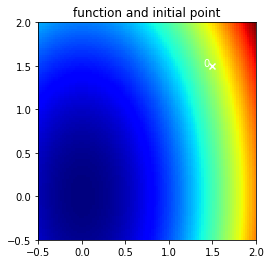

In [20]:
show_traj(np.array([[1.5,1.5]]), title = "function and initial point")

# Classic Gradient Descent

In [21]:
def GD(alpha = 0.1,z0 = np.array([1.5,1.5]), epsilon=0.1):
    """
        Runs Gradient Descent until accuracy epsilon // how about for some time horizon T ?
    """
    Tmax = 1000
    Z = [z0]
    G = [df(z0)] 
    C = [0]
    
    while len(Z)<Tmax: 
        zprev = Z[-1]
        gprev = G[-1]
        znext = zprev-alpha*gprev
        Z.append(znext)
        G.append(df(znext))
        C.append(len(z0))
        if np.linalg.norm(G[-1])<epsilon**(1/2):
            #STOPING CONDITION
            #Previous stopping was: f(zprev)-f(znext)<epsilon: 
            break

    if len(Z)>=Tmax:
        print("WARNING convergence has failed, max number of interations is reached!")
        
    return (np.array(Z),C)

oracle calls : 26
number of iterations : 14


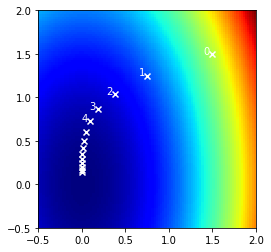

In [22]:
H = np.array([[3,0],[0,1]])
alpha = 1/12 # 1/6 would be optimal 
epsilon = 0.1

ZGD, CGD = GD(epsilon = epsilon, alpha = alpha) ## 1/6 would be optimal
print("oracle calls :", np.sum(CGD))
print("number of iterations :", len(ZGD))
show_traj(ZGD,title = "", savename = "", colorbar = False)

Text(0.5, 1.0, 'In log scale')

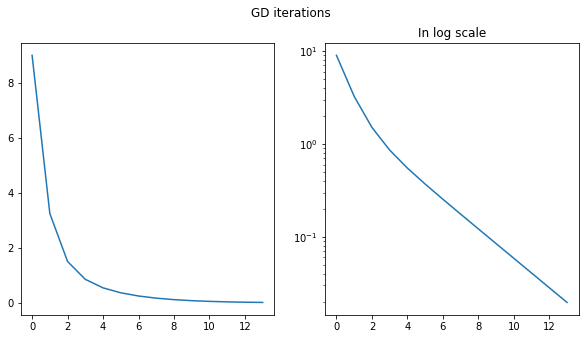

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('GD iterations')

ax1.plot([f(ZGD[i]) for i in range(len(ZGD))])

ax2.set_title("performance")
ax2.plot([f(ZGD[i]) for i in range(len(ZGD))])
ax2.set_yscale("log")
ax2.set_title("In log scale")

In [24]:
def LRGD(alpha = 0.1,z0 = np.array([1.5,1.5]), rank=1, epsilon=0.1):
    """a better implementation"""
    Z = [z0] # point
    G = [] # gradient
    C = [0] # oracle cost
    
    def GD_iter():
        #compute
        g = df(Z[-1])
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(len(z0))
    
    def LR_iter():
        #print("lr iter : ", len(Z))
        #print("current pos : ", Z[-1])
        
        #compute
        g = deltaf(Z[-1],G[-1])*G[-1]/np.linalg.norm(G[-1])
        #g = df(Z[-1]).dot(G[-1])/np.linalg.norm(G[-1])*G[-1]
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(rank)
        #print("next pos : ", Z[-1])
        
        
    GD_iter()
    
    while np.linalg.norm(G[-1]) > epsilon**(1/2): 
        #print("hi", np.linalg.norm(G[-1]))
        
        LR_iter()
        
        if np.linalg.norm(G[-1]) < epsilon**(1/2): 
        
            GD_iter()
    
    return (np.array(Z),C)

oracle calls :  25
number of iterations :  22


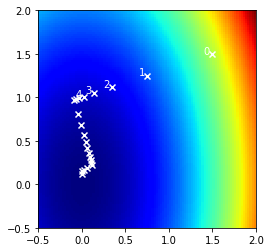

In [25]:
ZLRGD,CLRGD = LRGD(epsilon=0.1, alpha = alpha)
print("oracle calls : ", np.sum(CLRGD))
print("number of iterations : ", len(ZLRGD))
show_traj(ZLRGD,title = "",colorbar = False)

In [26]:
d = 3
r = 2
T = 10
G = np.ones((T,d))
G[-r:].shape
G[-r:]

array([[1., 1., 1.],
       [1., 1., 1.]])

In [27]:
G[-1:].T.shape

(3, 1)

In [28]:
np.linalg.svd(G[-1:].T,full_matrices=False)

(array([[0.57735027],
        [0.57735027],
        [0.57735027]]), array([1.73205081]), array([[1.]]))

In [29]:
def LRGD_r(alpha = 0.1,z0 = np.array([1.5,1.5]), rank=1, epsilon=0.1):
    """
        Implementation of LRGD for rank r
    """
    Z = [z0] # point
    G = [] # gradient
    C = [0] # oracle cost
    
    def GD_iter():
        #compute
        g = df(Z[-1])
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(len(z0))
    
    def LR_iter():
        """Only called after len(G)>=r"""
        
        # Previous gradients are in columns of G[-r:].T
        # They are orthonormalised by svd and then lie as columns of U
        U, _ , _ = np.linalg.svd(np.array(G[-rank:]).T,full_matrices=False)
        g = deltafU(Z[-1],U)
        znext = Z[-1]-alpha*g
        
        #update
        Z.append(znext)
        G.append(g)
        C.append(rank)
        #print("next pos : ", Z[-1])
    
    # INITIALIZATION
    for _ in range(rank):
        GD_iter()
    
    # RUNNING
    while np.linalg.norm(G[-1]) > epsilon**(1/2): 
        #print("hi", np.linalg.norm(G[-1]))
        
        LR_iter()
        
        if np.linalg.norm(G[-1]) < epsilon**(1/2): 
        
            GD_iter()
    
    return (np.array(Z),C)

oracle calls :  25
number of iterations :  22


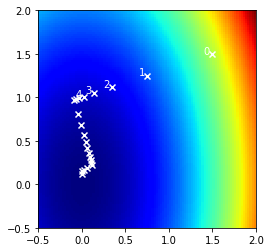

In [103]:
ZLRGD,CLRGD = LRGD_r(epsilon=0.1, alpha = alpha, rank=1)
print("oracle calls : ", np.sum(CLRGD))
print("number of iterations : ", len(ZLRGD))
show_traj(ZLRGD,title = "",colorbar = False)

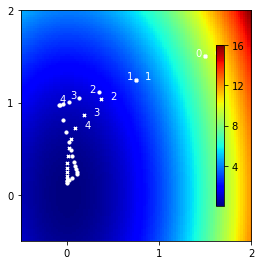

In [65]:
show_trajs(ZGD,ZLRGD,title = "",savename = "GD_LRGD.pdf",colorbar = True)

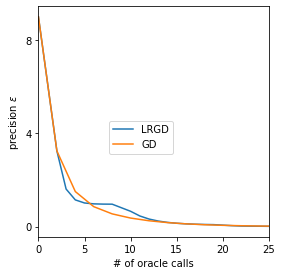

In [66]:
#### PLOT OF LRGD - by oracle call
fig, ax = plt.subplots(figsize = (4,4))
ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label ="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label = "GD")
ax.set_xlim(left = 0, right = np.sum(CLRGD))
fig.legend(loc="center")
plt.xticks([0,5,10,15,20,25])
plt.yticks([0,4,8])
plt.ylabel("precision $\epsilon$")
plt.xlabel("# of oracle calls")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.savefig("GD_LRGD_iterations.pdf")

In [14]:
f(ZGD[-1])

0.019654968102330743

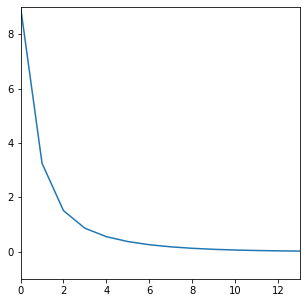

In [15]:
plt.subplots(figsize=(5, 5))
plt.xlim([0,13])
plt.ylim([-1,9])
plt.plot([f(ZGD[i]) for i in range(len(ZGD))])
plt.savefig("GD_iterations.pdf")

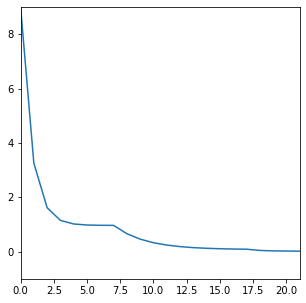

In [16]:
#### ENCAPSULATE THIS IN NICE PLOTS
plt.subplots(figsize = (5,5))

plt.xlim([0,21])
plt.ylim([-1,9])
plt.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])

for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax1.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)

plt.savefig("LRGD_iterations.pdf") 

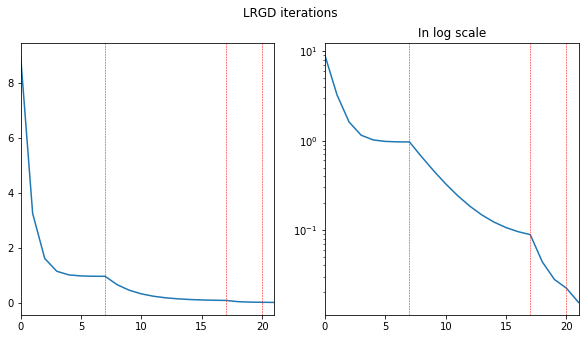

In [17]:
#### ENCAPSULATE THIS IN NICE PLOTS
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('LRGD iterations')

ax1.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax1.set_xlim(left = 0, right = len(ZLRGD)-1)

ax2.set_title("performance")
ax2.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax2.set_xlim(left = 0, right = len(ZLRGD)-1)
ax2.set_yscale("log")
ax2.set_title("In log scale")


for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax1.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        

(0, 13)

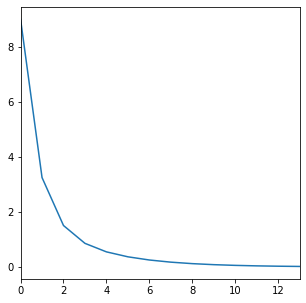

In [18]:
#### PLOT OF GD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZGD[i]) for i in range(len(ZGD))])
ax.set_xlim(left = 0, right = len(ZGD)-1)

(0, 21)

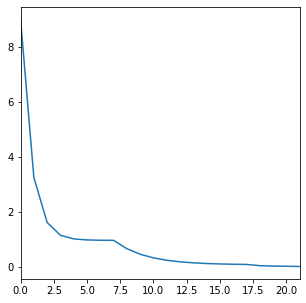

In [19]:
#### PLOT OF LRGD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = len(ZLRGD)-1)

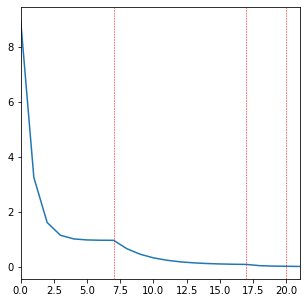

In [20]:
#### PLOT OF LRGD
fig, ax = plt.subplots(figsize = (5,5))
ax.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = len(ZLRGD)-1)
for i,c in enumerate(CLRGD):
    if c==2 and i>2: 
        ax.axvline(x = i-1, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)

(0, 25)

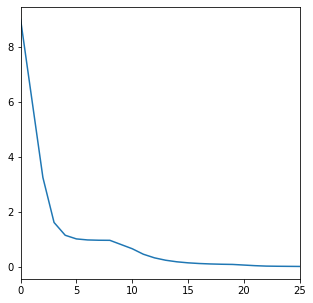

In [21]:
#### PLOT OF LRGD - by oracle call
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax.set_xlim(left = 0, right = np.sum(CLRGD))

(0, 26)

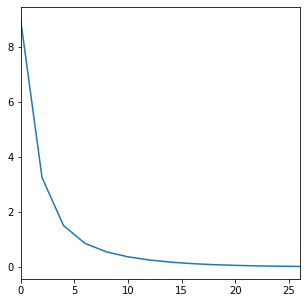

In [22]:
#### PLOT OF GD - by oracle call
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))])
ax.set_xlim(left = 0, right = np.sum(CGD))

In [105]:
### NOTE : could relate complexity of LRGD to complexity of Newton's method??? no -> but to complexity of line search. 


# Higher dimension

In [106]:
H = np.array(
    [[100,0,0],
     [0,10,0],
     [0,0,1]])

alpha = 1/100/10

In [107]:
ZGD,CGD = GD(z0 = np.array([1,1,1]),alpha = alpha, epsilon=0.01)
print("oracle calls : ", np.sum(CGD))

oracle calls :  4491


In [108]:
ZLRGD,CLRGD = LRGD(z0 = np.array([1,1,1]),alpha = alpha, epsilon=0.01)
print("oracle calls : ", np.sum(CLRGD))

oracle calls :  3022


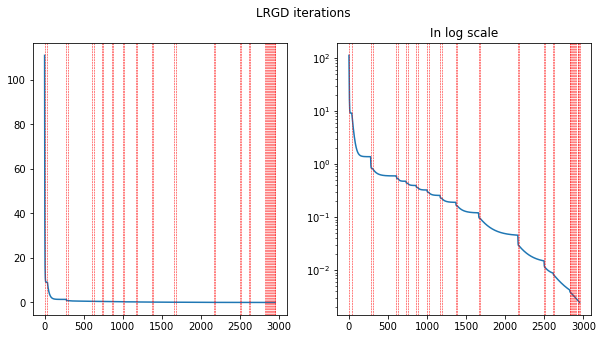

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
fig.suptitle('LRGD iterations')

ax1.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])

ax2.set_title("performance")
ax2.plot([f(ZLRGD[i]) for i in range(len(ZLRGD))])
ax2.set_yscale("log")
ax2.set_title("In log scale")


for i,c in enumerate(CLRGD):
    if c>1: 
        ax1.axvline(x = i, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        ax2.axvline(x = i, color = 'r', label = 'axvline - full height', linestyle = "--", linewidth = 0.5)
        

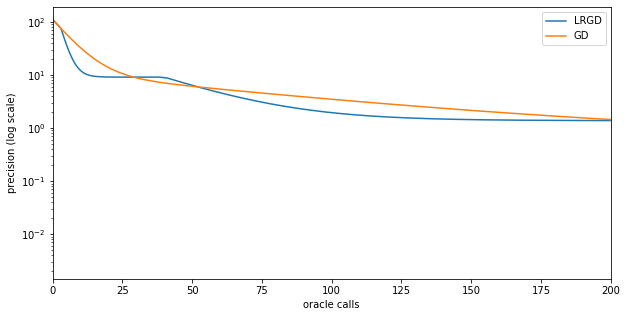

In [110]:
### TRANSPOSE !!!!!!!!!!!!!!

fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label="GD")
ax.set_yscale("log")
ax.set_ylabel("precision (log scale)")
ax.set_xlabel("oracle calls")
ax.set_xlim(left=0,right=200)
ax.legend()
fig.savefig("GDvsLRGD.png")

# More experiments

oracle calls GD :  14
oracle calls LRGD :  11


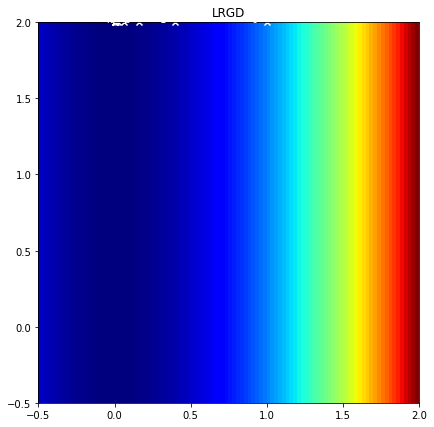

In [111]:
H = np.array(
    [[3,0],
     [0,0]])

z0 = np.array([1,2])

ZGD,CGD = GD(z0 = z0,epsilon=0.0001)
print("oracle calls GD : ", np.sum(CGD))

ZLRGD,CLRGD = LRGD(z0 = z0,epsilon=0.0001)
print("oracle calls LRGD : ", np.sum(CLRGD))

show_traj(ZLRGD,title = "LRGD")

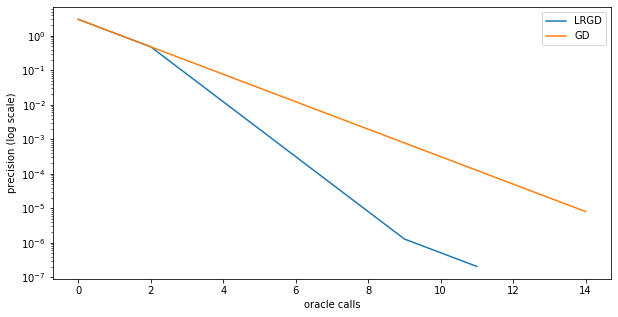

In [112]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(np.cumsum(CLRGD),[f(ZLRGD[i]) for i in range(len(ZLRGD))],label="LRGD")
ax.plot(np.cumsum(CGD),[f(ZGD[i]) for i in range(len(ZGD))],label="GD")
ax.set_yscale("log")
ax.set_ylabel("precision (log scale)")
ax.set_xlabel("oracle calls")
ax.legend()
fig.savefig("GDvsLRGD.png")

# Large scale experiments

In [125]:
### NEED TO ADAPT LEARNING RATE
### alpha = 1/L where L is smoothness of gradient. i.e. max singular value


H1 = np.array([[1,0],
               [0,1]])

H2 = np.array([[10,0],
               [0,1]])

H3 = np.array([[100,0],
                [0,1]])

H4 = np.array([[1000,0],
                [0,1]])


Hs = [H1,H2,H3,H4]

alphas = np.array([1, 1/10, 1/100,1/1000])/2 #/2 is optimal

z0s = np.array([[1,0],
                [0.87,0.5], #sin(30)
                [0.71,0.71],#à peu près 1/sqrt(2)
                [0.5,0.87],
                [0,1]]) 

columns = [str(el) for el in Hs]
indices = [str(el) for el in z0s]
data_lrgd = np.zeros(shape = (len(indices),len(columns)))
data_gd = np.zeros(shape = (len(indices),len(columns)))
#zdata = {}

for j in range(len(Hs)): 
    for i in range(len(z0s)):
        H = Hs[j]
        ZLRGD,C = LRGD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
        data_lrgd[i,j] = np.sum(C)
        ZGD,C = GD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
        data_gd[i,j] = np.sum(C)
        #zdata[str(i)+","+str(j)]=ZLRGD.copy()

results_lrgd = pd.DataFrame(columns = columns,index = indices, data = data_lrgd)
results_gd = pd.DataFrame(columns = columns,index = indices, data = data_gd)

results_lrgd

,[[1 0] [0 1]],[[10 0] [ 0 1]],[[100 0] [ 0 1]],[[1000 0] [ 0 1]]
[1. 0.],5.0,5.0,5.0,5.0
[0.87 0.5 ],5.0,20.0,130.0,1190.0
[0.71 0.71],5.0,26.0,166.0,1536.0
[0.5 0.87],5.0,31.0,195.0,1746.0
[0. 1.],5.0,22.0,188.0,1848.0


In [126]:
results_gd

,[[1 0] [0 1]],[[10 0] [ 0 1]],[[100 0] [ 0 1]],[[1000 0] [ 0 1]]
[1. 0.],2.0,2.0,2.0,2.0
[0.87 0.5 ],2.0,22.0,230.0,2302.0
[0.71 0.71],2.0,30.0,300.0,3004.0
[0.5 0.87],2.0,34.0,340.0,3410.0
[0. 1.],2.0,36.0,368.0,3688.0


In [127]:
# INTERPRETATION
# dans les directions où le learning rate est trop bas (pcq le learning rate est conçu pour les directions les plus coûteuses)
# 

In [445]:
i = 1
j = 1
H = Hs[j]
ZLRGD,C = LRGD(z0 = z0s[i],epsilon=0.1, alpha = alphas[j])
np.sum(C)

35

In [446]:
ZLRGD

array([[ 8.70000000e-01,  5.00000000e-01],
       [ 4.35000000e-01,  4.75000000e-01],
       [ 2.16855577e-01,  4.62462964e-01],
       [ 1.07460199e-01,  4.56175873e-01],
       [ 5.26004480e-02,  4.53023014e-01],
       [ 2.50893016e-02,  4.51441914e-01],
       [ 1.12929724e-02,  4.50649021e-01],
       [ 4.37436954e-03,  4.50251401e-01],
       [ 2.18718477e-03,  4.27738831e-01],
       [ 1.18562436e-04,  4.06446617e-01],
       [-1.83792447e-03,  3.86308607e-01],
       [-3.68835456e-03,  3.67262234e-01],
       [-5.43847694e-03,  3.49248323e-01],
       [-7.09372906e-03,  3.32210906e-01],
       [-8.65925364e-03,  3.16097049e-01],
       [-1.01399146e-02,  3.00856689e-01],
       [-1.15403122e-02,  2.86442475e-01],
       [-1.28647974e-02,  2.72809624e-01],
       [-1.41174851e-02,  2.59915779e-01],
       [-1.53022675e-02,  2.47720881e-01],
       [-1.64228254e-02,  2.36187041e-01],
       [-1.74826403e-02,  2.25278425e-01],
       [-1.84850051e-02,  2.14961141e-01],
       [-1.

In [447]:
ZLRGD

array([[ 8.70000000e-01,  5.00000000e-01],
       [ 4.35000000e-01,  4.75000000e-01],
       [ 2.16855577e-01,  4.62462964e-01],
       [ 1.07460199e-01,  4.56175873e-01],
       [ 5.26004480e-02,  4.53023014e-01],
       [ 2.50893016e-02,  4.51441914e-01],
       [ 1.12929724e-02,  4.50649021e-01],
       [ 4.37436954e-03,  4.50251401e-01],
       [ 2.18718477e-03,  4.27738831e-01],
       [ 1.18562436e-04,  4.06446617e-01],
       [-1.83792447e-03,  3.86308607e-01],
       [-3.68835456e-03,  3.67262234e-01],
       [-5.43847694e-03,  3.49248323e-01],
       [-7.09372906e-03,  3.32210906e-01],
       [-8.65925364e-03,  3.16097049e-01],
       [-1.01399146e-02,  3.00856689e-01],
       [-1.15403122e-02,  2.86442475e-01],
       [-1.28647974e-02,  2.72809624e-01],
       [-1.41174851e-02,  2.59915779e-01],
       [-1.53022675e-02,  2.47720881e-01],
       [-1.64228254e-02,  2.36187041e-01],
       [-1.74826403e-02,  2.25278425e-01],
       [-1.84850051e-02,  2.14961141e-01],
       [-1.

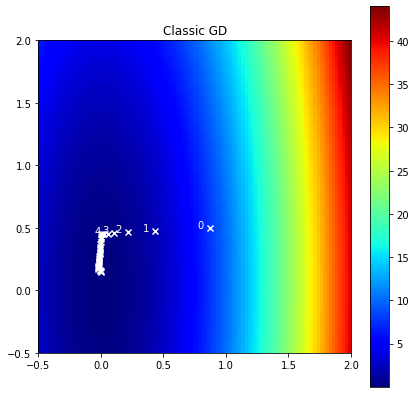

In [448]:
show_traj(ZLRGD,title = "Classic GD")

In [449]:
zdata['1,2']

NameError: name 'zdata' is not defined

## More complex problems

### Synthetic OLS regression (would a complex regularizer be interesting?)

In [130]:
##  REGRESSION SETTING
##
## Y[i] = X[i,:]\beta + \sigma N(0,1)

n=20
p=5
sigma = 0.1
X = np.random.normal(size = (n,p)) 
beta = np.ones(shape = (p)) #replace with np.random.normal(size = (p))
eps = np.random.normal(size = (n))
Y = X.dot(beta) + sigma*eps

## Relevant learning rate 
alpha = 1/(2*np.linalg.norm(2*X.T.dot(X))) ## relevant cause the norm of hessian is upper bound on biggest singular value

In [131]:
np.linalg.norm(Y - X.dot(beta))

0.37396670654192

In [132]:
betah, residuals, rank, s = np.linalg.lstsq(X,Y)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [133]:
np.linalg.norm(betah-beta)

0.05501013546495801

In [134]:
betah

array([1.01495189, 0.99598832, 0.9912344 , 0.97824661, 1.04729077])

In [135]:
## Define the corresponding functions
def f(beta):
    """f(beta) = ||Xbeta-Y||^2"""
    return np.linalg.norm(X.dot(beta)-Y)**2

def df(beta):
    return 2*X.T.dot(X.dot(beta)-Y)

def deltaf(z,u):
    """returns directional derivative of f along u"""
    return df(z).dot(u)/np.linalg.norm(u)

def deltafU(z,U):
    """
    U =(u_1 | u_2 ... | u_r) orthonormal columns
    return projection of gradient on U
    """
    s = 0 
    d,r = U.shape
    for i in range(r):
        ui = U[:,i]
        s += deltaf(z,ui)*ui
    return s

In [136]:
print("at optimum:", df(betah))
print("at zero:", df(np.ones(p)))

at optimum: [ 2.04281037e-14 -3.71924713e-15 -3.59712260e-14 -1.06581410e-14
 -9.29811783e-15]
at zero: [ 0.05805591 -0.03805815  0.14067184  0.54140188 -1.33890675]


In [138]:
ZGD, CGD = GD(epsilon = 0.001, alpha = alpha, z0 = np.zeros(p), Tmax=1000) ## 1/6 would be optimal
np.sum(CGD)

355

In [137]:
ZLRGD, CLRGD = LRGD_r(epsilon=0.001, alpha = alpha, z0 = np.zeros(p), rank=p)
np.sum(CLRGD)

365

In [150]:
columns = ["rank 1", "rank 2", "rank 3", "rank 4", "rank 5", "rank 6","rank p (= GD)"]
ranks = [1,2,3,4,5,6,p]
indices = ["1/2L", "1/4L", "1/8L"]
alphas=[alpha, alpha/2,alpha/4]
data = np.zeros(shape = (len(indices),len(columns)))

for j in range(len(columns)): 
    for i in range(len(indices)):
        ZLRGD,C = LRGD_r(z0 = np.zeros(p),epsilon=0.1, alpha = alphas[i], rank=ranks[j])
        data[i,j] = np.sum(C)

results = pd.DataFrame(columns = columns,index = indices, data = data)
results

,rank 1,rank 2,rank 3,rank 4,rank 5,rank 6,rank p (= GD)
1/2L,157.0,211.0,233.0,238.0,245.0,287.0,245.0
1/4L,281.0,406.0,443.0,466.0,485.0,575.0,485.0
1/8L,519.0,784.0,866.0,922.0,970.0,1157.0,970.0


In [72]:
betah

array([1.00517249, 1.02290266, 0.95238129, 0.99825745, 0.99871228])

In [115]:
ZGD


45600

In [117]:
ZLRGD
np.sum(CLRGD)

7075

In [151]:
## PLANTED STRUCTURE

n=1000
p=100
sigma = 0.1
r=4
X = np.random.normal(size = (n,r)).dot(np.random.normal(size=(r,p))) 
beta = np.ones(shape = (p)) #replace with np.random.normal(size = (p))
eps = np.random.normal(size = (n))
Y = X.dot(beta) + sigma*eps

## Relevant learning rate 
alpha = 1/(2*np.linalg.norm(2*X.T.dot(X))) ## relevant cause the norm of hessian is upper bound on biggest singular value

In [152]:
columns = ["rank 1", "rank 2", "rank 3", "rank 4", "rank 5", "rank 6","rank p (= GD)"]
ranks = [1,2,3,4,5,6,p]
indices = ["1/2L", "1/4L", "1/8L"]
alphas=[alpha, alpha/2,alpha/4]
data = np.zeros(shape = (len(indices),len(columns)))

for j in range(len(columns)): 
    for i in range(len(indices)):
        ZLRGD,C = LRGD_r(z0 = np.zeros(p),epsilon=0.1, alpha = alphas[i], rank=ranks[j])
        data[i,j] = np.sum(C)

results = pd.DataFrame(columns = columns,index = indices, data = data)
results

,rank 1,rank 2,rank 3,rank 4,rank 5,rank 6,rank p (= GD)
1/2L,1221.0,1112.0,894.0,724.0,875.0,1024.0,10000.0
1/4L,1475.0,1458.0,1227.0,988.0,1205.0,1420.0,12700.0
1/8L,1977.0,2256.0,1893.0,1512.0,1860.0,2206.0,25800.0


In [78]:
ZGD, CGD = GD(epsilon = 0.001, alpha = alpha, z0 = np.zeros(p), Tmax=1000) ## 1/6 would be optimal
np.sum(CGD)

8800

In [81]:
ZLRGD, CLRGD = LRGD_r(epsilon=0.001, alpha = alpha, z0 = np.zeros(p), rank=5)
np.sum(CLRGD)

1020

## Least squares with L1 regularizer

In [105]:
##  REGRESSION SETTING
##
## Y[i] = X[i,:]\beta + \sigma N(0,1)

n=1000
p=100
sigma = 0.1
X = np.random.normal(size = (n,p)) 
beta = np.ones(shape = (p)) #replace with np.random.normal(size = (p))
eps = np.random.normal(size = (n))
Y = X.dot(beta) + sigma*eps

## Relevant learning rate 
alpha = 1/(2*np.linalg.norm(2*X.T.dot(X))) ## relevant cause the norm of hessian is upper bound on biggest singular value

In [106]:
## Define the corresponding functions
def f(beta):
    """f(beta) = ||Xbeta-Y||^2"""
    return np.linalg.norm(X.dot(beta)-Y)**2+np.linalg.norm(beta, ord=1)

def df(beta):
    return 2*X.T.dot(X.dot(beta)-Y) + np.sign(beta)

def deltaf(z,u):
    """returns directional derivative of f along u"""
    return df(z).dot(u)/np.linalg.norm(u)

def deltafU(z,U):
    """
    U =(u_1 | u_2 ... | u_r) orthonormal columns
    return projection of gradient on U
    """
    s = 0 
    d,r = U.shape
    for i in range(r):
        ui = U[:,i]
        s += deltaf(z,ui)*ui
    return s

In [107]:
ZGD, CGD = GD(epsilon = 0.001, alpha = alpha, z0 = np.zeros(p), Tmax=1000) ## 1/6 would be optimal
np.sum(CGD)

45600

In [114]:
ZLRGD, CLRGD = LRGD_r(epsilon=0.001, alpha = alpha, z0 = np.zeros(p), rank=5)
np.sum(CLRGD)

7075

In [91]:
np.linalg.norm(beta, ord=1)

5.0

In [92]:
beta

array([1., 1., 1., 1., 1.])

In [93]:
np.sign(beta)

array([1., 1., 1., 1., 1.])

In [94]:
beta[2]=-10

In [95]:
np.sign(beta)

array([ 1.,  1., -1.,  1.,  1.])

In [127]:
r=20
X = np.random.normal(size = (n,r)).dot(np.random.normal(size=(r,p))) 

In [128]:
u,s,vh = np.linalg.svd(X)

In [129]:
s

array([4.42114947e+02, 4.20094185e+02, 4.08499064e+02, 3.94412546e+02,
       3.76305513e+02, 3.60056692e+02, 3.55698787e+02, 3.44647230e+02,
       3.32307480e+02, 3.22333608e+02, 3.18548471e+02, 2.99768060e+02,
       2.76671981e+02, 2.58102581e+02, 2.56892231e+02, 2.49526051e+02,
       2.34785832e+02, 2.13148479e+02, 1.92468830e+02, 1.92382417e+02,
       2.04606969e-13, 1.30794474e-13, 1.23317015e-13, 1.10611903e-13,
       1.06167496e-13, 1.00832921e-13, 9.42294415e-14, 8.72567543e-14,
       8.42076127e-14, 8.13811285e-14, 7.30318896e-14, 7.25405681e-14,
       6.74522970e-14, 6.67356139e-14, 6.19744613e-14, 5.91091253e-14,
       5.57154921e-14, 5.42610147e-14, 4.93140127e-14, 4.51099711e-14,
       3.75754859e-14, 3.55524663e-14, 3.45732559e-14, 3.45732559e-14,
       3.45732559e-14, 3.45732559e-14, 3.45732559e-14, 3.45732559e-14,
       3.45732559e-14, 3.45732559e-14, 3.45732559e-14, 3.45732559e-14,
       3.45732559e-14, 3.45732559e-14, 3.45732559e-14, 3.45732559e-14,
      